# Tema 18: Inferencia básica

:::{important}
Para esta libreta utilizaremos la libería `scipy`, que ya debería estar instalada en en entorno local, pero si no, puedes utilizar `uv add scipy` en tu terminal. La librería ya está preinstalada en colab.
:::

En esta librería continuaremos trabajando con la el dataset **palmer penguins** y realizaremos algunas de las pruebas inferenciales más comunes.

Antes de iniciar, revisa la documentación de `scipy` [aquí](https://scipy.org/)

## Librerías

In [4]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
print('librerías cargadas')

librerías cargadas


Similar a `matplotlib` importamos un "submódulo" de `scipy` que se llama `stats`.

## Cargar datos


In [3]:
url = 'https://raw.githubusercontent.com/raphaelvallat/pingouin/refs/heads/main/src/pingouin/datasets/penguins.csv'

df = pd.read_csv(url)
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female
1,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male
2,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female
3,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male
4,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male


## Pruebas de bondad de ajuste

Pese al gran [debate](https://stats.stackexchange.com/questions/2492/is-normality-testing-essentially-useless) que existe en torno a este tipo de pruebas, son muy utilizadas así que veremos cómo hacerlas.

Lo que se prueba es la hipótesis nula de que los datos provienen de una determinada distribución paramétrica, principalmente la normal.

Veremos tres pruebas:
1. Shapiro-Wilk (SW)
2. Kolmogórov-Smirnov (KS)
3. Anderson-Darling (AD)

Scipy implementa también otras, pero no las veremos en el curso.

Seleccionaremos una variable específica (`body_mass_g`) para las pruebas y acompañaremos el análisis con un histograma con densidad.

### Visualización de distribución


Text(0.5, 1.0, 'Distribución de peso')

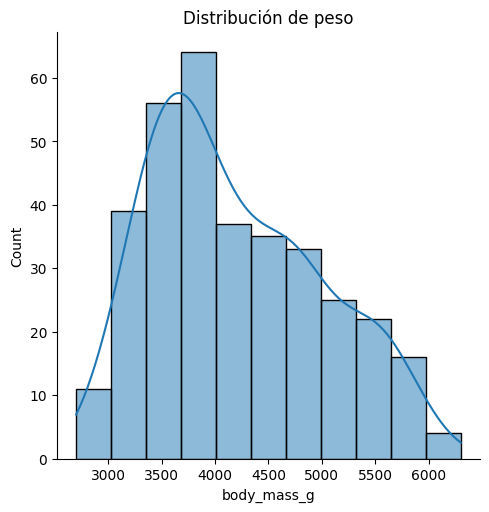

In [9]:
sns.displot(
    data=df,
    x='body_mass_g',
    kde=True,
)
plt.title('Distribución de peso')

Podemos ver una distribución con asimetría positiva, probablemente porque tenemos tres subpoblaciones, podemos separar cada población, agregando una línea o dos más.

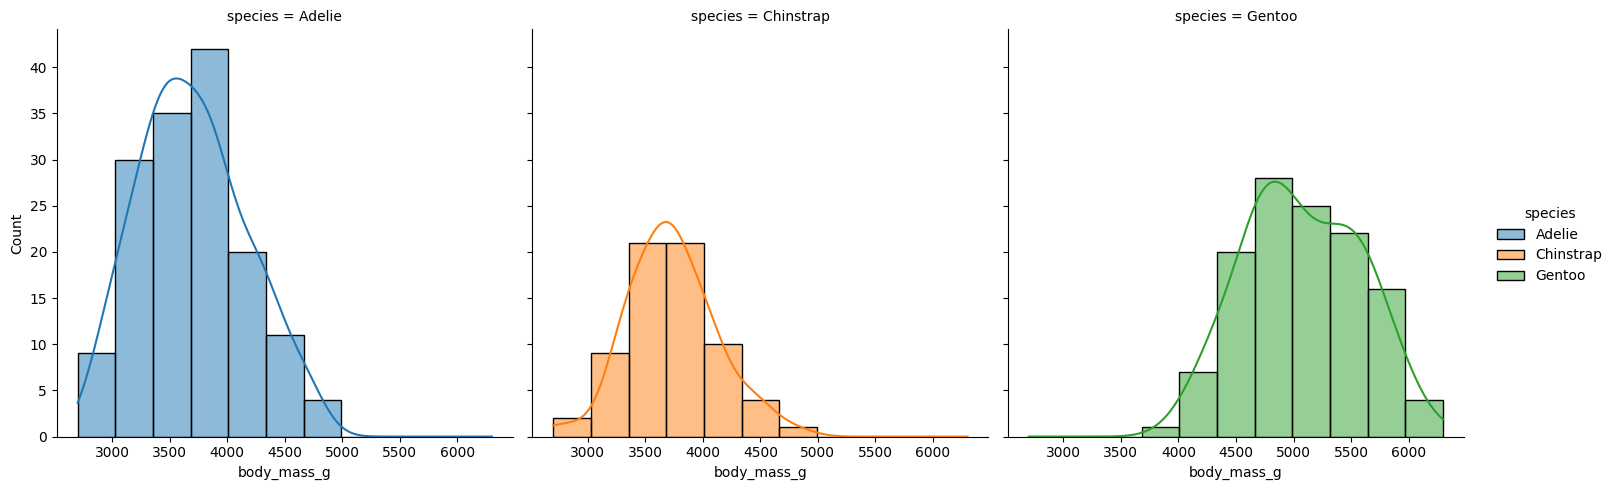

In [11]:
g = sns.displot(
    data=df,
    x='body_mass_g',
    kde=True,
    col='species',
    hue='species', # solo para el color
)


Separando las subpoblaciones podemos ver distribuciones aproximadamente normales.

### Shapiro-Wilk

In [ ]:
peso = df['body_mass_g'].dropna() # quitamos los pingüinos con datos faltantes

stats.shapiro(peso)

ShapiroResult(statistic=np.float64(0.9592111774906512), pvalue=np.float64(3.6790392409769466e-08))

La prueba de shapiro para toda la población arroja una p menor a 0.05 que no permite rechazar la hipótesis de que los datos no son normales.
Repitamos la prueba por cada subpoblación.

In [ ]:
for especie in df['species'].unique(): # elejimos los valores únicos
    filtro = df['species'] == especie
    peso = df[filtro]['body_mass_g'].dropna()
    print(especie, 'n=', len(peso)) # queremos también saber la n
    resultado = stats.shapiro(peso)
    print(resultado)

Adelie n= 151
ShapiroResult(statistic=np.float64(0.9807078507062779), pvalue=np.float64(0.03239702501304091))
Chinstrap n= 68
ShapiroResult(statistic=np.float64(0.984493761674102), pvalue=np.float64(0.5605082387697975))
Gentoo n= 123
ShapiroResult(statistic=np.float64(0.9859276066609362), pvalue=np.float64(0.23361648888961845))


Vemos que solo en la subpoblación de pingüinos Adelie, la prueba de Shapiro indica normalidad.

Probemos ahora el mismo procedimiento con la prueba de KS.

### Kolmogórov-Smirnov

En la prueba de KS probamos una hipótesis general, pero la prueba corrobora la bondad de ajuste a cualquier tipo de distribución que debemos especificar.

Scipy contiene prácticamente todas las distribuciones paramétricas habituales, la normal está en `stats.norm`.

In [23]:
peso = df['body_mass_g'].dropna()
z = (peso - peso.mean()) / peso.std() # estandarizamos
stats.kstest(
    z, 
    cdf=stats.norm.cdf # queremos probar la distribución normal
)

KstestResult(statistic=np.float64(0.10408424225215168), pvalue=np.float64(0.0011141206447900635), statistic_location=np.float64(-0.5009690301398295), statistic_sign=np.int8(1))

Nuevamente tenemos un resultado no normal, separemos por especie.

In [ ]:
for especie in df['species'].unique(): # elejimos los valores únicos
    filtro = df['species'] == especie
    peso = df[filtro]['body_mass_g'].dropna()
    z = (peso - peso.mean()) / peso.std() # estandarizamos
    print(especie, 'n=', len(peso)) # queremos también saber la n
    resultado = stats.kstest(z, cdf=stats.norm.cdf)
    print(resultado)

Adelie n= 151
KstestResult(statistic=np.float64(0.07246097564635684), pvalue=np.float64(0.3876243471754205), statistic_location=np.float64(-0.3285507654029253), statistic_sign=np.int8(1))
Chinstrap n= 68
KstestResult(statistic=np.float64(0.09265913723429497), pvalue=np.float64(0.5714776097492497), statistic_location=np.float64(0.17409746844960372), statistic_sign=np.int8(1))
Gentoo n= 123
KstestResult(statistic=np.float64(0.0681309311837266), pvalue=np.float64(0.5934927015323732), statistic_location=np.float64(0.8410436105945132), statistic_sign=np.int8(-1))


Esta vez vemos que las tres subpoblaciones son normales.

:::{note}
En la prueba de KS debemos estandarizar para probar el resultado.
Estandarizar significa convertir los valores de los datos a puntuaciones z.
La fórmula de la puntuación z es:
$z = \frac{x-\bar{x}}{s}$
Donde $\bar{x}$ es la media, *s* es la desviación estándar y *x* es el dato.
:::

Veamos ahora la prueba de Anderson Darling:

### Anderson Darling
Es una prueba derivada de KS pero específicamente para la distribución normal.

Probemos nuevamente para toda la muestra.

In [24]:
peso = df['body_mass_g'].dropna()
stats.anderson(peso)

AndersonResult(statistic=np.float64(4.543039287872375), critical_values=array([0.569, 0.649, 0.778, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(4201.754385964912), scale=np.float64(801.9545356980955))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

La prueba nos dice que el estadístico es 4.54 y para una significancia del 5% (p < 0.05) el punto de corte sería 0.778, por lo cual no podemos rechazar la hipótesis de que los datos no son normales.

#### Ejercicio
Ejecuta la prueba de AD para cada una de las subpoblaciones.

## Resultados con Scipy
La gran mayoría de las pruebas estadísticas con `scipy` devuelven un objeto que se llama `NamedTuple`. Estos objetos son muy fáciles de utilizar y nos ayudan a extraer los valores individuales de cada resultado. Para saber qué valores contine un resultado, es necesario ver su documentación. Pongamos de ejemplo la prueba de SW nuevamente.


In [ ]:
peso = df['body_mass_g'].dropna()
resultado = stats.shapiro(peso)

print('Valor p:', resultado.pvalue)
print('Estadístico:', resultado.statistic)

Valor p: 3.6790392409769466e-08
Estadístico: 0.9592111774906512


Esto nos ayuda a generar reportes automatizados de la siguiente manera. Seleccionaremos solo la población de Chinstrap.

In [ ]:
chinstrap = df[df['species'] == 'Chinstrap']
for var in chinstrap.select_dtypes(float): # seleccionamos las numéricas
    datos = chinstrap[var].dropna()
    resultado = stats.shapiro(datos)
    p = resultado.pvalue
    normal = "sí es normal" if p > 0.05 else "no es normal"

    print(f'La variable "{var}" {normal}, p={p:.4f}')


La variable "bill_length_mm" sí es normal, p=0.1941
La variable "bill_depth_mm" sí es normal, p=0.1418
La variable "flipper_length_mm" sí es normal, p=0.8106
La variable "body_mass_g" sí es normal, p=0.5605


### Ejercicio
Replícalo para las demás especies.

## Pruebas de asociación bivariadas
Veremos ahora cómo realizar pruebas de asociación, usaremos solo $X^2$ y la exacta de fisher.

### Chi cuadrada

Primero vamos cómo generar tablas cruzadas con `pandas`, para ello, seleccionaremos dos variables, `species` y `island`. 


In [37]:
matriz = pd.crosstab(
    df['island'],  # filas
    df['species'], # columnas
)
matriz

species,Adelie,Chinstrap,Gentoo
island,,,
Biscoe,44,0,124
Dream,56,68,0
Torgersen,52,0,0


Esto nos genera una tabla con la cuenta de pingüinos que cumplen con cada valor de ambas variables. Vemos que los Adelie viven en las tres islas, mientras que los Chinstrap y Gentoo solo viven en Dream y Biscoe respectivamente.

Guardamos además la tabla en la variable `matriz`.

Ahora ejecutemos la $X^2$.

In [38]:
stats.chi2_contingency(matriz)

Chi2ContingencyResult(statistic=np.float64(299.55032743148195), pvalue=np.float64(1.354573829719252e-63), dof=4, expected_freq=array([[74.23255814, 33.20930233, 60.55813953],
       [54.79069767, 24.51162791, 44.69767442],
       [22.97674419, 10.27906977, 18.74418605]]))

Esta corresponde a la chi cuadrada de independencia y vemos que el valor p es menor a 0.05. También podemos ver que en las frecuencias esperadas no hay celdas con menos de 5 valores y el tamaño de muestra es apropiado.

Veamos ahora la prueba de fisher.

### Exacta de Fisher
Para esta prueba requerimos una tabla 2x2, así que utilizaremos la variable `sex` y crearemos una nueva variable, `peso_bajo_media` en la cual veremos si el peso de un pingüino está por debajo de la media.

In [39]:
peso_bajo_media = df['body_mass_g'] < df['body_mass_g'].mean()
matriz = pd.crosstab(
    df['sex'],
    peso_bajo_media
)
matriz

body_mass_g,False,True
sex,,
female,53,112
male,92,76


Vemos ahora que tenemos una tabla 2x2, con nuestra variable calculada. 
Ahora ejecutemos la prueba de fisher.

In [40]:
stats.fisher_exact(matriz)

SignificanceResult(statistic=np.float64(0.390916149068323), pvalue=np.float64(4.046749537813585e-05))

Podemos ver que existe una asociación entre el sexo y tener peso debajo de la media. Ajustemos el análisis para ver si es el sexo `female` el asociado.

In [ ]:
peso_bajo_media = df['body_mass_g'] < df['body_mass_g'].mean()
female = df['sex'] == 'female'
matriz = pd.crosstab(
    female,
    peso_bajo_media
)
matriz

body_mass_g,False,True
sex,,
False,98,81
True,53,112


Algo raro pasó, las cuentas no son iguales, y esto se debe a que en el arreglo de datos hay faltantes, para poder analizar bien esta asociación necesitamos solo datos completos, lo haremos de la siguiente manera.

In [ ]:
datos_completos = df.dropna(subset=['sex', 'body_mass_g']) 
# quita las filas que en las que falte cualquiera de las
# dos variables
peso_bajo_media = datos_completos['body_mass_g'] < datos_completos['body_mass_g'].mean()
female = datos_completos['sex'] == 'female'
matriz = pd.crosstab(
    female,
    peso_bajo_media
)
matriz

body_mass_g,False,True
sex,,
False,92,76
True,53,112


Esta vez las cuentas se ven bien, hagamos nuevamente la prueba.

In [47]:
stats.fisher_exact(matriz)

SignificanceResult(statistic=np.float64(2.558093346573982), pvalue=np.float64(4.046749537813585e-05))

Y generemos el OR

In [44]:
stats.contingency.odds_ratio(matriz, kind='sample')

OddsRatioResult(statistic=2.558093346573982)

Vemos que los pingüinos hembra tienen 2.5 veces más odds de estar por debajo del peso medio, lo cual podría estar relacionado con dimorfismo sexual.

### Ejercicio
Analiza el arreglo de datos y realiza otras comparaciones de asociación.

## Pruebas AB

Las pruebas AB básicamente comparan dos series de datos y podemos pensarlas como un contraste entre una variable categórica (grupo) y una cuantitativa. Entre las pruebas AB más utilizadas están las pruebas **t** y las versiones no paramétricas basadas en rango como la U de Mann Whitney. Veamos cómo realizarlas.

### T de Student

Pleanteemos la siguiente hipótesis:

$H_1: Peso_{hembras} \ne Peso_{machos}$

Utilizaremos las variables de la sección previa.

In [48]:
datos_completos.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female
1,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male
2,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female
3,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male
4,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male


In [49]:
female.head()

0     True
1    False
2     True
3    False
4    False
Name: sex, dtype: bool

Como female es una serie de datos booleanos, podemos usarla como filtro, para separar los valores de machos y hembras.

In [50]:
peso = datos_completos['body_mass_g']
peso_hembras = peso[female]
peso_machos = peso[~female] # ~ es el operador "not" 
                            # es decir "not female"
# ahora hacemos la prueba T

stats.ttest_ind( # ind es independientes
    peso_hembras, peso_machos
)

TtestResult(statistic=np.float64(-8.541720337994516), pvalue=np.float64(4.897246751596224e-16), df=np.float64(331.0))

Vemos que el valor p es muy inferior a 0.05, lo cual corrobora nuestra hipótesis.

Existe una variante de la prueba t que no asume varianzas iguales, la prueba **t de Welch**, veamos cómo aplicarla ahora.

In [51]:
stats.ttest_ind( # ind es independientes
    peso_hembras, peso_machos,
    equal_var=False, # no asumimos varianzas iguales
)

TtestResult(statistic=np.float64(-8.554537231165762), pvalue=np.float64(4.793891255051492e-16), df=np.float64(323.89588102864843))

En este caso el resultado no se modifica gran cosa.


### U de Mann Whitney

Si quisieramos realizar la prueba no paramétrica de rangos de U de Mann Whiney, lo haríamos de la siguiente forma.

In [52]:
stats.mannwhitneyu(peso_hembras, peso_machos,)

MannwhitneyuResult(statistic=np.float64(6874.5), pvalue=np.float64(1.8133343032461053e-15))

## Correlación
Existen varias pruebas de correlación pero las tres principalmente utilizadas son r de Pearson, rho de Spearman y Tau de Kendall, veamos cómo ejecutarlas.
Para esto, seleccionaremos dos variables cuantitativas, en este ejemplo `flipper_length_mm` y `bill_length_mm`.

Primero separemos las series de interés.

In [54]:
datos_completos = df.dropna(subset=['flipper_length_mm', 'bill_length_mm'])
flippers = datos_completos['flipper_length_mm']
bill = datos_completos['bill_length_mm']

Ahora las correlaciones.
### Pearson


In [55]:
stats.pearsonr(flippers, bill)

PearsonRResult(statistic=np.float64(0.656181340746428), pvalue=np.float64(1.7439736176203663e-43))

### Spearman

In [56]:
stats.spearmanr(flippers, bill)

SignificanceResult(statistic=np.float64(0.6727719416255544), pvalue=np.float64(2.0669356276079494e-46))

### Kendall

In [57]:
stats.kendalltau(flippers, bill)

SignificanceResult(statistic=np.float64(0.48334544176274524), pvalue=np.float64(1.7471887323081624e-39))

En los tres casos encontramos una relación directa moderada y estadísticamente significativa entre las variables.
Visualicémoslo.

### Visualización

<Axes: xlabel='flipper_length_mm', ylabel='bill_length_mm'>

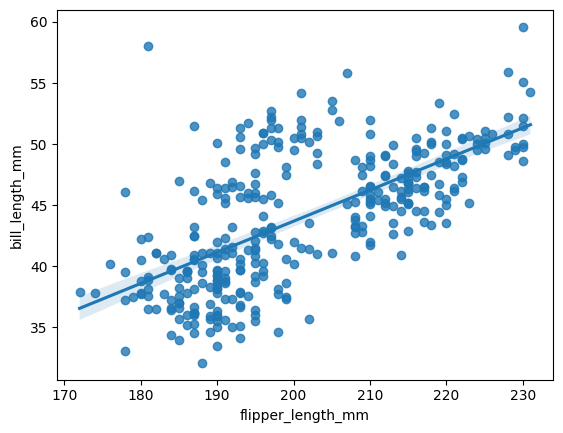

In [60]:
sns.regplot(
    x=flippers, 
    y=bill,
)

### Ejercicio
Genera una visualización y las tres correlaciones para las tres diferentes especies.